In [1]:
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
# TELFIT
from telfit import TelluricFitter, DataStructures, FittingUtilities

def read_giano_spec(file, order):
    '''read single giano file and order
    and return WAVELENGTH, FLUX, FLUX_ERR, HEADER for that frame, order'''

    # read from FITS file
    hdul = fits.open(file)
    hdr = hdul[0].header
    data = hdul[1].data
    nOrders = len(data)
    
    _, x, y, yerr = hdul[1].data[nOrders-1-order] # wave1 in nm
    sort = np.argsort(x)
    x, y, yerr = x[sort], y[sort], yerr[sort]
    
    return x,y,yerr,hdr

def mask_saturated_lines(x,y, sat_threshold=0.05, dx=20):
    '''given wavelength vector `x` and flux values `y` 
    return mask where saturated lines are True'''
    sat = y < sat_threshold # identify saturated peaks
    
    # Mask the telluric lines by masking the region around the saturated peaks
    # dx = 15 # boundary masked out around the peak
    badregions = []
    for i in np.argwhere(sat==True):
        ind = int(i)
        sat[ind-dx:ind+dx] = True
        badregions.append([x[ind-dx], x[ind+dx]])
        
    return sat, badregions

/home/dario/anaconda3/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/dario/anaconda3/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


### Read GIANO files

In [2]:
night = '1'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)


wave, flux, flux_err, hdrs = ([] for _ in range(4))
files = sorted(glob.glob(data_dir+'*ms1d.fits'))
order = 49
for f in files:
    x,y,yerr,hdr = read_giano_spec(f, order)
    wave.append(x)
    flux.append(y)
    flux_err.append(yerr)
    hdrs.append(hdr)

dc = Datacube(wlt=np.array(wave), flux=np.array(flux), flux_err=np.array(flux_err))


### Create MASTER spectrum (time-average) and fit a telluric model 

In [3]:
# Define data object for TelFit, data is the MASTER spectrum
data = DataStructures.xypoint(x=np.median(dc.wlt, axis=0), y=np.median(dc.flux, axis=0))

 # Mask out SATURATED LINES
cont = FittingUtilities.Continuum(x, y, fitorder=3, lowreject=1.5, highreject=10)
mask, badregions = mask_saturated_lines(x, y / cont)


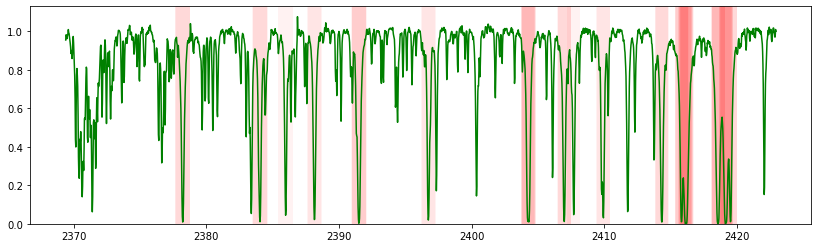

In [4]:
cont = FittingUtilities.Continuum(data.x, data.y, fitorder=3, lowreject=1.5, highreject=10)

sat, badregions = mask_saturated_lines(data.x, data.y/cont)

fig, ax = plt.subplots(1, figsize=(14,4))
# ax.plot(data.x[sat],data.y[sat]/cont[sat], '-r') # data of masked regions
# ax.plot(data.x[~sat],data.y[~sat]/cont[~sat], '-g') # data without masked regions
ax.plot(data.x,data.y/cont, '-g') # plot full data


# Masked regions
[ax.axvspan(badregions[k][0], badregions[k][1], fc='r', alpha=0.05) for k in range(len(badregions))]


ax.set_ylim(bottom=0.0)

plt.show()

In [5]:
# data.x = data.x[~sat]
# data.y = data.y[~sat]
# data.cont = cont[~sat]
print(data.x.shape, data.y.shape)

(2048,) (2048,)


In [6]:
class Parameter:
    
    def __init__(self, name, value, bounds, fit=False):
        self.name = name
        self.value = value
        self.bounds = bounds
        self.fit = fit

h2o = Parameter('h2o', 50., [1., 99.], fit=True)
co = Parameter('co', 0.1, [0.01, 1.], fit=True)
o2 = Parameter('o2', 2.2e5, [2e4, 2e6], fit=True)
R = Parameter('resolution', 50e3, [40e3, 60e3], fit=True)

In [7]:



fitter = TelluricFitter(print_lblrtm_output=False)

# COMMENT: altitude to the NEAREST KM (2.4 does not work)
observatory = {"latitude": 28.8, "altitude": 2.0}
fitter.SetObservatory(observatory)

for param in [h2o, co, o2, R]:
    fitter.FitVariable({param.name:param.value})
    fitter.SetBounds({param.name: param.bounds})

In [8]:
def get_median(hdrs, keyword):
    return np.median([hdrs[k][keyword] for k in range(len(hdrs))])

angle = 90. - np.degrees(get_median(hdrs, 'EL'))
pressure = get_median(hdrs, 'HIERARCH TNG METEO PRESSURE') #Pressure, in hPa
humidity = get_median(hdrs, 'HIERARCH TNG METEO HUMIDITY')  #Percent humidity, at the observatory altitude
temperature = 273.15 + get_median(hdrs, 'HIERARCH TNG METEO TEMP10M') #Temperature in Kelvin

In [9]:
import time
start = time.time()
    
# Set wavelength region for the fit
fitter.AdjustValue({"wavestart": data.x[0] - 2.0,
                    "waveend": data.x[-1] + 2.0,
                    "angle": angle,
                    "pressure": pressure,
                    "temperature": temperature})

primary, model, R = fitter.Fit(data=data.copy(),
                                       #Can give data here as well as separately like in the simpler fit example
                                       resolution_fit_mode="SVD",
                                       fit_source=True,  #Fit the broad stellar lines too
                                       return_resolution=True,  #Return the best fit resolution
                                       adjust_wave="data",  # Fit the wavelength data to the model
                                       wavelength_fit_order=3,
                                       air_wave=False)
end = time.time()
print('Elapsed time {:.2f} s'.format(end-start))

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	5.00000E+04	True		40000 - 60000
h2o            	5.00000E+01	True		1 - 99
co             	1.00000E-01	True		0.01 - 1
o2             	2.20000E+05	True		20000 - 2e+06
Warning, 137 of 100627 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	5.00000E+04	True		40000 - 60000
h2o            	5.00000E+01	True		1 - 99
co             	1.00000E-01	True		0.01 - 1
o2             	2.20000E+05	True		20000 - 2e+06
Warning, 137 of 100627 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	5.00000E+04	True		40000 - 60000
h2o            	5.00000E+01	True		1 - 99
co             	1.00000E-01	True		0.01 - 1
o2             	2.20000E+05	True		20000 - 2e+06
Warning, 137 of 100627 bins contained negative fluxes; they have been set t

/home/dario/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


Warning, 1 of 10991 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	4.16711E+04	True		40000 - 60000
h2o            	5.01662E+01	True		1 - 99
co             	1.00065E-01	True		0.01 - 1
o2             	2.20259E+05	True		20000 - 2e+06
Warning, 141 of 100627 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	4.78659E+04	True		40000 - 60000
h2o            	5.00167E+01	True		1 - 99
co             	1.00006E-01	True		0.01 - 1
o2             	2.20026E+05	True		20000 - 2e+06
Warning, 137 of 100627 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	4.85348E+04	True		40000 - 60000
h2o            	5.00167E+01	True		1 - 99
co             	1.00006E-01	True		0.01 - 1
o2             	2.20026E+05	True		20000 - 2

/home/dario/anaconda3/lib/python3.9/site-packages/TelluricFitter.py:1406: UserWarning: Warning! SVD Broadening function peaked at the wrong location! See SVD_Error2.log for the broadening function
  warnings.warn("Warning! SVD Broadening function peaked at the wrong location! "


Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	4.78659E+04	True		40000 - 60000
h2o            	5.00167E+01	True		1 - 99
co             	1.00006E-01	True		0.01 - 1
o2             	4.25362E+05	True		20000 - 2e+06
Warning, 137 of 100627 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	4.78659E+04	True		40000 - 60000
h2o            	5.00167E+01	True		1 - 99
co             	1.00005E-01	True		0.01 - 1
o2             	2.20030E+05	True		20000 - 2e+06
Warning, 137 of 100627 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 10996 bins contained negative fluxes; they have been set to zero.
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
resolution     	4.78659E+04	True		40000 - 60000
h2o            	5.00167E+01	True		1 - 99
co             	1.00006E-01	True		0.01 - 1
o2             	2.20026E+05	True		20000 - 2

(-0.5, 1.5)

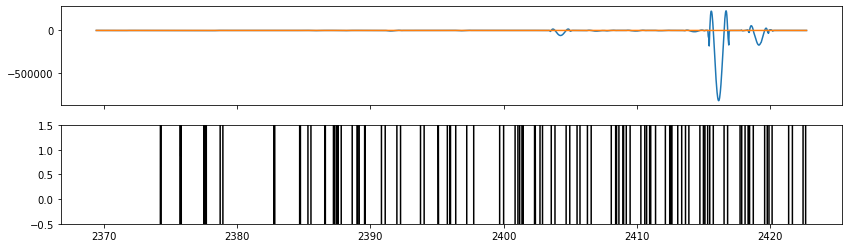

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14,4), sharex=True)
# ax.plot(fitter.data.x, fitter.data.y, label='Data')
# ax.plot(fitter.data.x, fitter.data.y, label='Data')
flux = fitter.data.y - fitter.data.cont
ax[0].plot(fitter.data.x, flux, label='Data')
ax[0].plot(model.x, model.y, label='Model')
ax[1].plot(model.x, flux - model.y, '-k', label='Residuals')

ax[1].set_ylim(-0.5, 1.5)

In [11]:
# TO-DO
# Problems with dividing by zero at around saturated lines

(2048,)